# On Analyzing Real World Time Series for Forecasting: Daily Minimum Temperate Data
- NOTES: [real_world_investigations-base.ipynb](https://github.com/Brinkley97/applied_time_series_and_machine_learning/blob/main/framework_for_time_series_data/real_world_investigations-base.ipynb) by Detravious

- TUTORIAL: [Autoregression Models for Time Series Forecasting With Python](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/) by Jason Brownlee

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
from data_loader import build_air_temperature_uts
from ts_models import Model, AR, PersistenceWalkForward, MA, EvaluationMetric
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Daily Minimum Temperate Data Pipeline

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc)
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation
6. Split Data
7. Initialize Autoregressive AR(p) Model
8. Predict Forecasts
9. Plot Actual Forecasts vs Predicted Forecasts
10. Initialize Persistence Random Walk Model
11. Predict Forecasts on Raw Data for Persistence Random Walk Model
12. Follow-up

### Load Raw Data

In [2]:
temperatures = build_air_temperature_uts()
temperatures

UnivariateTimeSeries(Temp)

- `class`: UnivariateTimeSeries
- `object`: temperatures
- `.method()`: get_as_df() and see more below

In [3]:
temp_df = temperatures.get_as_df()
temp_df

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


### Plot Raw Data

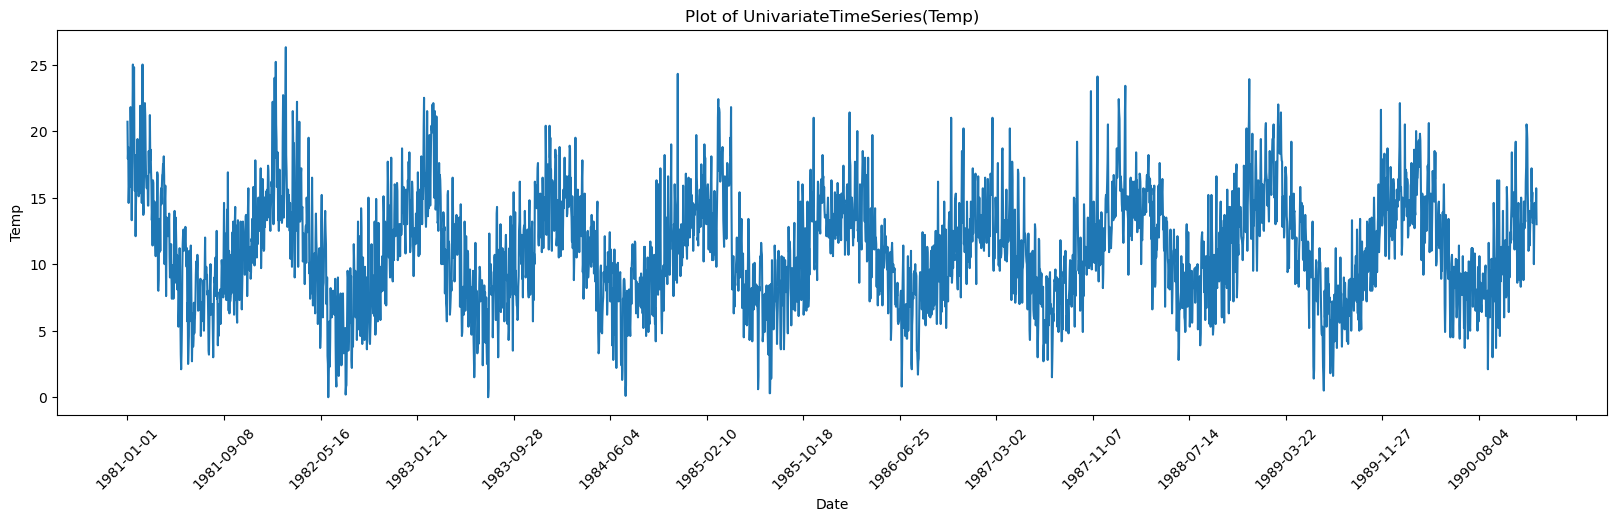

In [4]:
temperatures.plot(tick_skip=250)

### Get Descriptive Statistics

In [5]:
temperatures.get_statistics()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [6]:
temperatures.max_min_range()

{'Max': Temp    26.3
 dtype: float64,
 'Min': Temp    0.0
 dtype: float64,
 'Range': Temp    26.3
 dtype: float64}

### Check Stationarity of Raw Data

In [7]:
temperatures.stationarity_test(temp_df)

Series is stationary as 0.000247082630036107 < 0.05


### Plot Autocorrelation and Partial Autocorrelation
- How the relationship between observations and its historical data changes over time.
- In this case, we have a positive high autocorrelation meaning that we have some relationships between the 1st observation and the k-th observation (at that lag). 
- Look for which points fall outside of blue region.

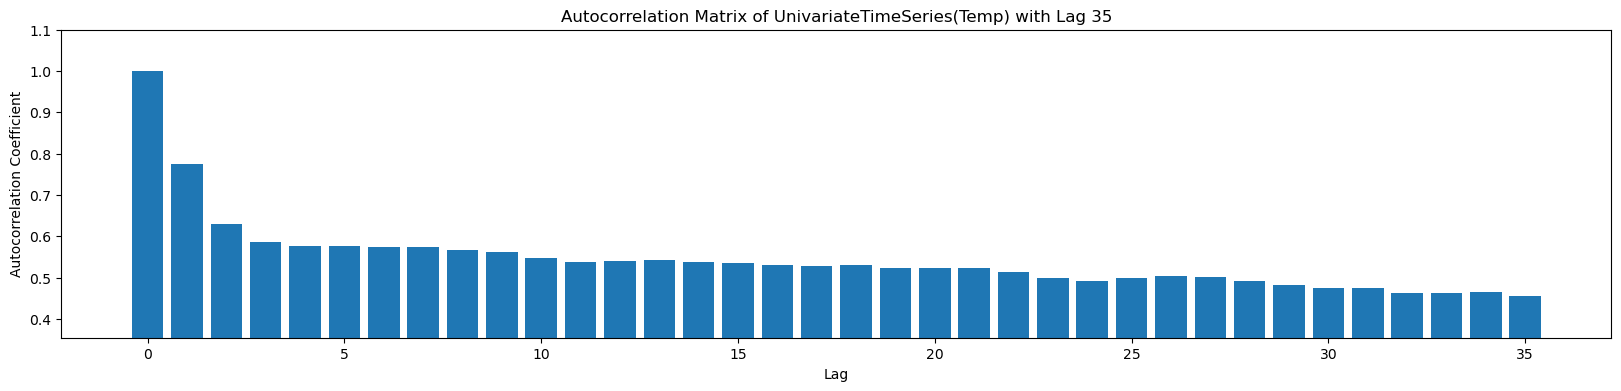

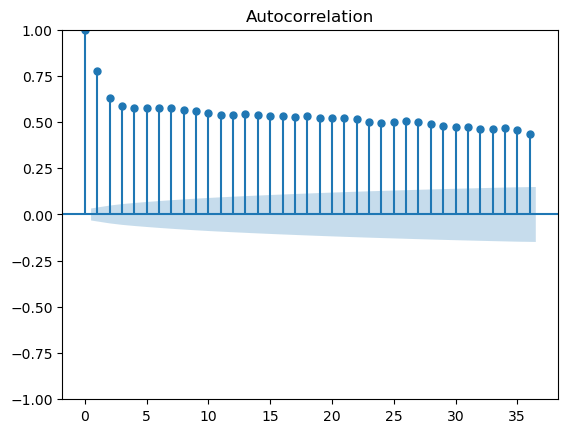

In [8]:
temperatures.plot_autocorrelation(35)

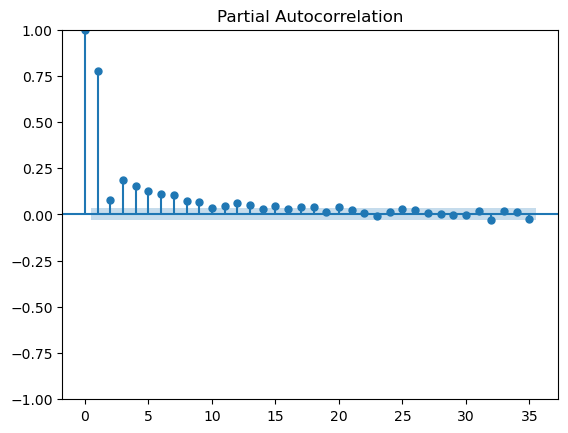

In [9]:
temperatures.plot_partial_autocorrelation(35)

### Split Data
- Splitting according to the TUTORIAL so we can forecast the last 7 days. Do this type of forecast to see how model is performing. If model performs how we need, then update notebook to forecast the next 7 days.

In [10]:
train, validation, test = temperatures.get_train_validation_test_split(0.9983, 0.0)

0 3643
3643 3643
3643 3650


In [11]:
train.get_as_df()

,UnivariateTimeSeries(Temp)[0:3643]
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-20,15.4
1990-12-21,13.1
1990-12-22,13.2


In [12]:
validation.get_as_df()

,UnivariateTimeSeries(Temp)[3643:3643]
Date,


In [13]:
test.get_as_df()

,UnivariateTimeSeries(Temp)[3643:3650]
Date,
1990-12-25,12.9
1990-12-26,14.6
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


In [14]:
expected_forecast = test.get_series()
expected_forecast

array([12.9, 14.6, 14. , 13.6, 13.5, 15.7, 13. ])

### Initialize AR Model
- How to determine the proper lag value? Look at the Partial ACor plot. Being that we're out of the blue area at lag 3, we'll set our lag to be 3. We'll also test for lag 31 which is the first negative lag that's outside of the blue. The TUTORIAL has lag 29, so we'll test that as well.
- How to understand the model summary?

In [24]:
lags_to_test = [3, 31, 29, 10]

In [25]:
ar_model_class = AR()

trained_ar_models = ar_model_class.train_ar_model(train.get_series(), lags_to_test)

Model 1 with a lag of 3
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3643
Model:                     AutoReg(3)   Log Likelihood               -8528.268
Method:               Conditional MLE   S.D. of innovations              2.519
Date:                Sun, 29 Oct 2023   AIC                          17066.536
Time:                        07:44:22   BIC                          17097.534
Sample:                             3   HQIC                         17077.577
                                 3643                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8883      0.134     14.093      0.000       1.626       2.151
y.L1           0.7003      0.016     43.027      0.000       0.668       0.732
y.L2          -0.0596      0

In [26]:
trained_ar_models[0]

In [27]:
trained_ar_models[1]

In [28]:
len_historical_data, historical_data = train.get_historical_data()
len_historical_data, historical_data

(3643, array([20.7, 17.9, 18.8, ..., 13.2, 13.9, 10. ]))

In [29]:
len_historical_data

3643

In [30]:
historical_data

array([20.7, 17.9, 18.8, ..., 13.2, 13.9, 10. ])

### Predict Forecasts on Raw Data for AR Model

In [31]:
predictions = ar_model_class.predict(trained_ar_models, len_historical_data, train, test)
predictions

Model 1 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x19f6693a0>
Model 2 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x19f9ca280>
Model 3 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x19f892fd0>
Model 4 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x19f806400>


[array([10.5704819 , 11.33521452, 11.09592451, 10.99117893, 11.07734647,
        11.09847037, 11.08823369]),
 array([11.82833838, 13.01359268, 13.55066252, 13.14955297, 13.02689956,
        13.13357498, 13.13550787]),
 array([11.87216021, 13.05570396, 13.53180951, 13.24259049, 13.09156377,
        13.14608181, 13.17649241]),
 array([11.47679312, 12.63726604, 13.0574664 , 13.03378918, 12.8259307 ,
        12.65767226, 12.43273596])]

In [32]:
mse_temperatures = EvaluationMetric.eval_mse(expected_forecast, predictions, per_element=True)
mse_temperatures

expected [12.9 14.6 14.  13.6 13.5 15.7 13. ] predicted [10.5704819  11.33521452 11.09592451 10.99117893 11.07734647 11.09847037
 11.08823369] mse 2.9766533485020883
expected [12.9 14.6 14.  13.6 13.5 15.7 13. ] predicted [11.82833838 13.01359268 13.55066252 13.14955297 13.02689956 13.13357498
 13.13550787] mse 1.2477795890410115
expected [12.9 14.6 14.  13.6 13.5 15.7 13. ] predicted [11.87216021 13.05570396 13.53180951 13.24259049 13.09156377 13.14608181
 13.17649241] mse 1.2252531298890241
expected [12.9 14.6 14.  13.6 13.5 15.7 13. ] predicted [11.47679312 12.63726604 13.0574664  13.03378918 12.8259307  12.65767226
 12.43273596] mse 1.563819622086078


### Plot Actual Forecasts vs Predicted Forecasts

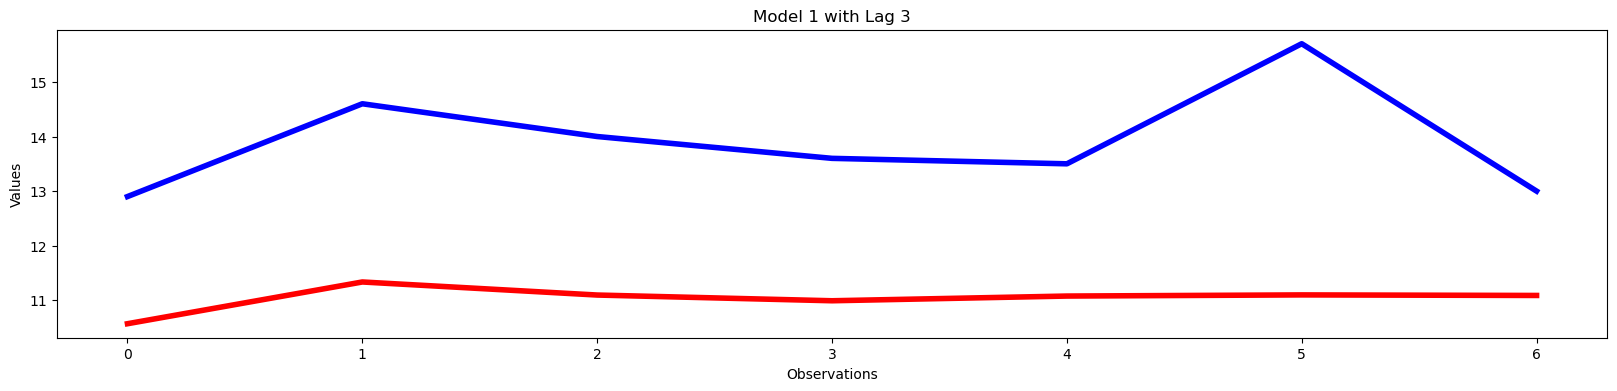

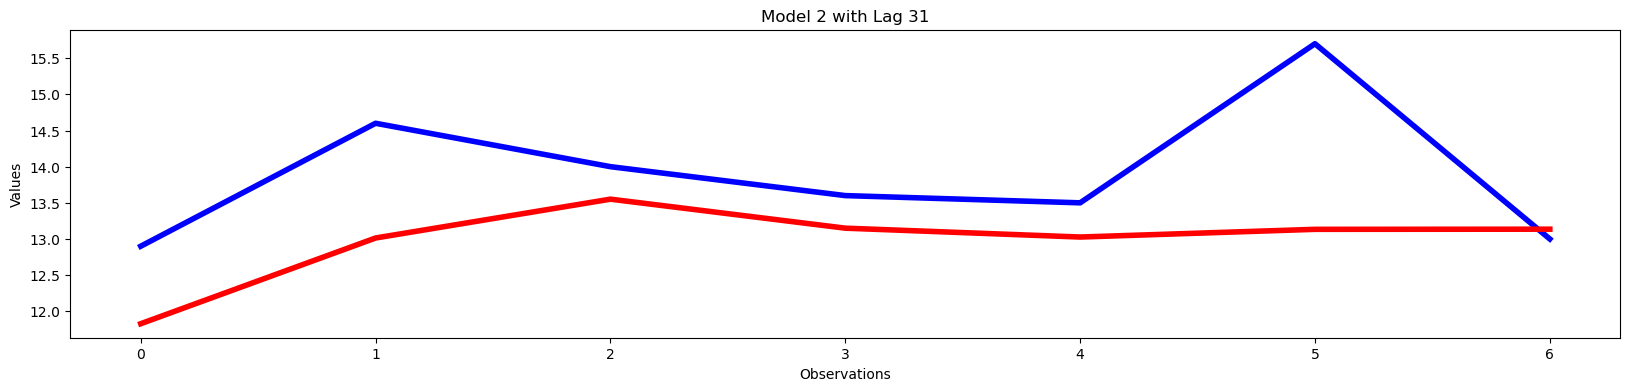

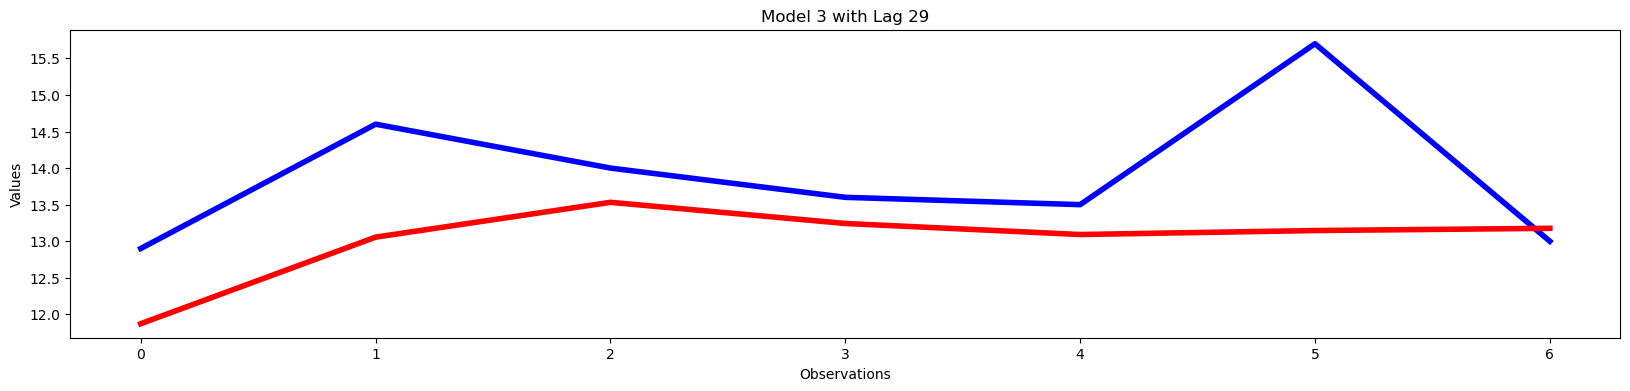

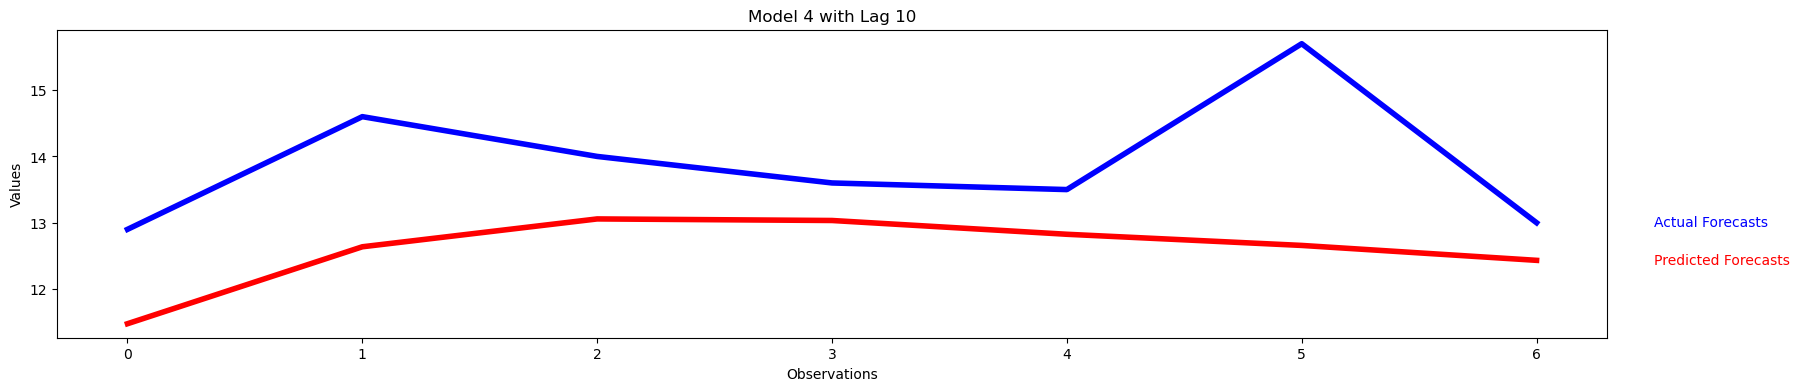

In [33]:
EvaluationMetric.plot_forecast(expected_forecast, predictions, lags_to_test, with_lags=True)

### Initialize Persistence Random Walk Model

In [34]:
temp_df

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


In [35]:
temp_values = temperatures.get_series()
temp_values

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [36]:
temp_lags_df = pd.concat([temp_df.shift(1), temp_df], axis=1)
temp_lags_df

,Temp,Temp
Date,,
1981-01-01,NaN,20.7
1981-01-02,20.7,17.9
1981-01-03,17.9,18.8
1981-01-04,18.8,14.6
1981-01-05,14.6,15.8
...,...,...
1990-12-27,14.6,14.0
1990-12-28,14.0,13.6
1990-12-29,13.6,13.5


In [37]:
temp_lags_df.columns = ['t - 1', 't + 1']
temp_lags_df

,t - 1,t + 1
Date,,
1981-01-01,NaN,20.7
1981-01-02,20.7,17.9
1981-01-03,17.9,18.8
1981-01-04,18.8,14.6
1981-01-05,14.6,15.8
...,...,...
1990-12-27,14.6,14.0
1990-12-28,14.0,13.6
1990-12-29,13.6,13.5


In [38]:
X = temp_lags_df.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [39]:
len(train), len(test), len(train_X), len(train_y), len(test_X), len(test_y)

(3642, 7, 3642, 3642, 7, 7)

In [40]:
prw_model = PersistenceWalkForward()
prw_model

PersistenceWalkForward()

### Predict Forecasts on Raw Data for Persistence Random Walk Model

In [41]:
prw_predictions = prw_model.predict(test_X)
prw_predictions = np.array(prw_predictions)
prw_predictions

Predicted Forecasts: [10.0]
Predicted Forecasts: [10.0, 12.9]
Predicted Forecasts: [10.0, 12.9, 14.6]
Predicted Forecasts: [10.0, 12.9, 14.6, 14.0]
Predicted Forecasts: [10.0, 12.9, 14.6, 14.0, 13.6]
Predicted Forecasts: [10.0, 12.9, 14.6, 14.0, 13.6, 13.5]
Predicted Forecasts: [10.0, 12.9, 14.6, 14.0, 13.6, 13.5, 15.7]


array([10. , 12.9, 14.6, 14. , 13.6, 13.5, 15.7])

In [42]:
test_y

array([12.9, 14.6, 14. , 13.6, 13.5, 15.7, 13. ])

In [43]:
mse_temperatures = EvaluationMetric.eval_mse(test_y, prw_predictions, per_element=False)
mse_temperatures

Test MSE: 3.423


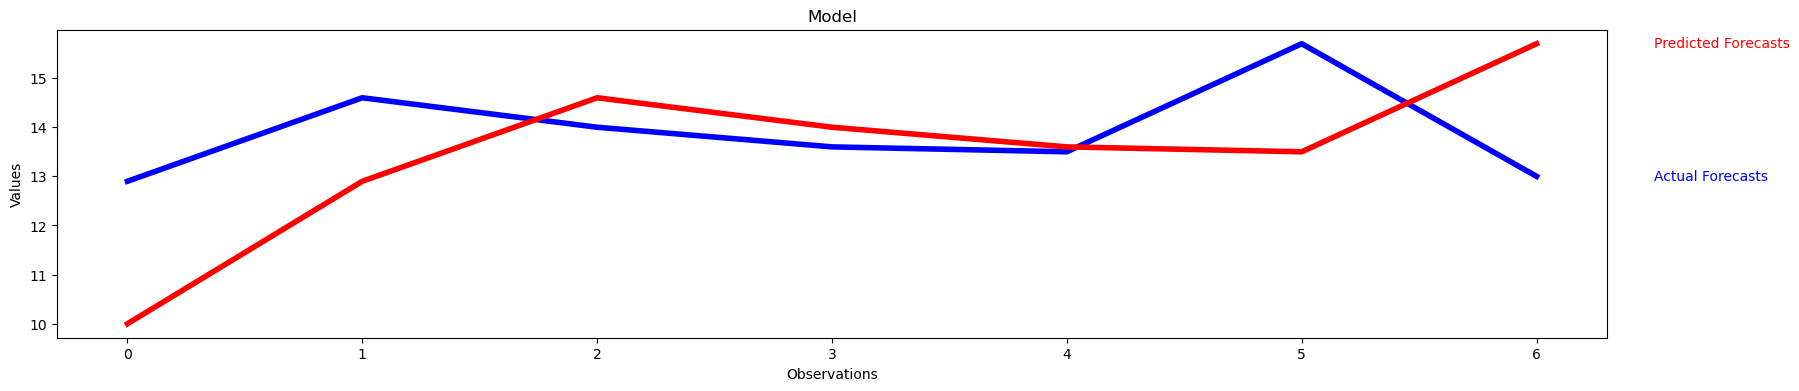

In [44]:
lags_to_test = [0]
EvaluationMetric.plot_forecast(test_y, prw_predictions, lags_to_test, with_lags=False)

### Initialize MA(q) Model

- How to determine the proper error term? Look at the ACor plot. There's no real indication of what values to choose, so I'll randomly pick some. 
- How to understand the model summary?

In [45]:
train, validation, test = temperatures.get_train_validation_test_split(0.9983, 0.0)

0 3643
3643 3643
3643 3650


In [46]:
errors_to_test = [3, 8, 17, 31, 29]

In [47]:
ma_model_class = MA()

trained_ma_models = ma_model_class.train_model(train.get_series(), errors_to_test)

MA( 3 )
MA( 8 )
MA( 17 )
MA( 31 )
MA( 29 )


In [48]:
ma_predictions = ma_model_class.predict(trained_ma_models, len_historical_data, train, test)
ma_predictions

MA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x19f9523a0> )
MA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x19fa04df0> )
MA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x19f952610> )
MA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x19fa134f0> )
MA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x19f9fc130> )


[array([11.59996233, 12.39588948, 11.72507574, 11.24903363, 11.95051902,
        11.3213506 , 11.95854902]),
 array([11.59996233, 12.39588948, 11.72507574, 11.24903363, 11.95051902,
        11.3213506 , 11.95854902]),
 array([11.59996233, 12.39588948, 11.72507574, 11.24903363, 11.95051902,
        11.3213506 , 11.95854902]),
 array([11.59996233, 12.39588948, 11.72507574, 11.24903363, 11.95051902,
        11.3213506 , 11.95854902]),
 array([11.59996233, 12.39588948, 11.72507574, 11.24903363, 11.95051902,
        11.3213506 , 11.95854902])]

In [49]:
expected_forecast = test.get_series()
expected_forecast

array([12.9, 14.6, 14. , 13.6, 13.5, 15.7, 13. ])

In [50]:
mse_temperatures = EvaluationMetric.eval_mse(expected_forecast, ma_predictions, per_element=True)
mse_temperatures

expected [12.9 14.6 14.  13.6 13.5 15.7 13. ] predicted [11.59996233 12.39588948 11.72507574 11.24903363 11.95051902 11.3213506
 11.95854902] mse 2.387724750424176
expected [12.9 14.6 14.  13.6 13.5 15.7 13. ] predicted [11.59996233 12.39588948 11.72507574 11.24903363 11.95051902 11.3213506
 11.95854902] mse 2.387724750424176
expected [12.9 14.6 14.  13.6 13.5 15.7 13. ] predicted [11.59996233 12.39588948 11.72507574 11.24903363 11.95051902 11.3213506
 11.95854902] mse 2.387724750424176
expected [12.9 14.6 14.  13.6 13.5 15.7 13. ] predicted [11.59996233 12.39588948 11.72507574 11.24903363 11.95051902 11.3213506
 11.95854902] mse 2.387724750424176
expected [12.9 14.6 14.  13.6 13.5 15.7 13. ] predicted [11.59996233 12.39588948 11.72507574 11.24903363 11.95051902 11.3213506
 11.95854902] mse 2.387724750424176


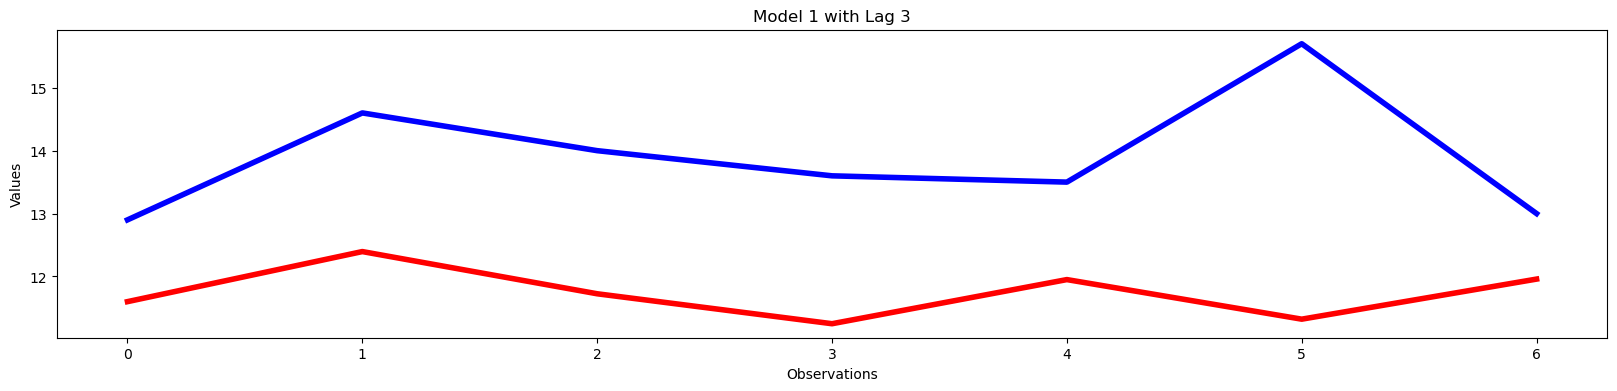

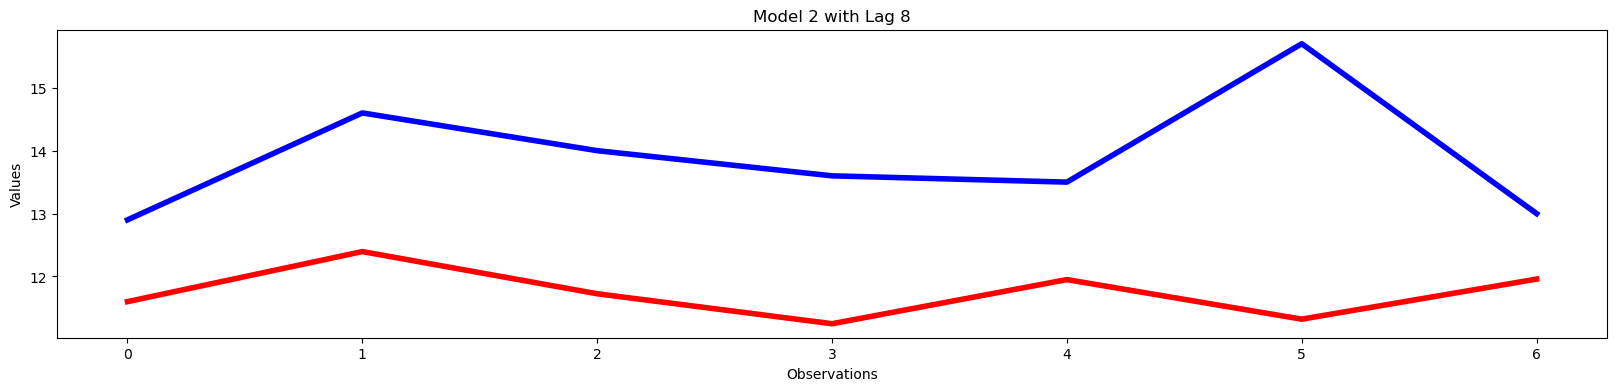

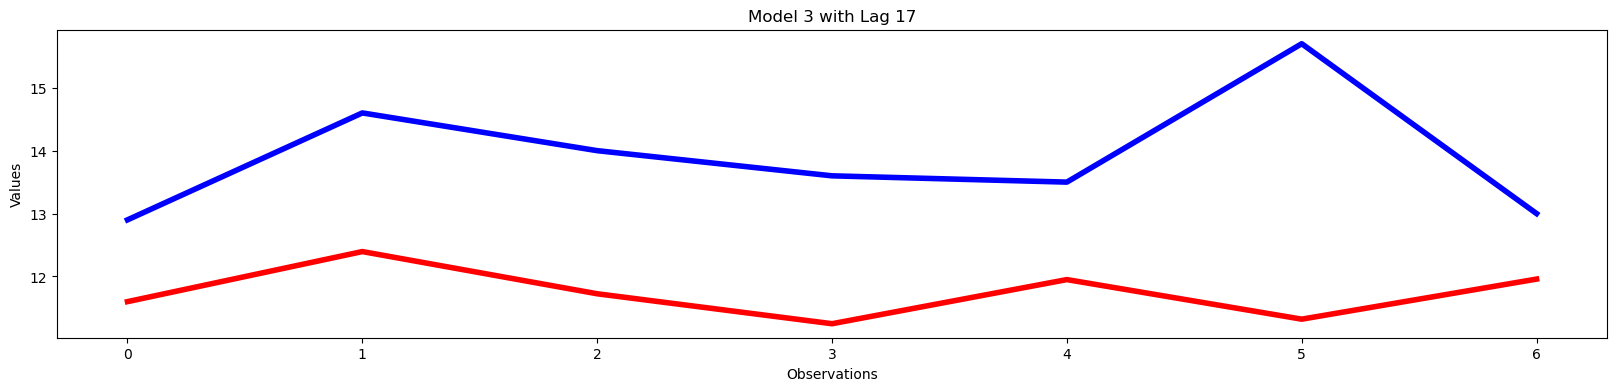

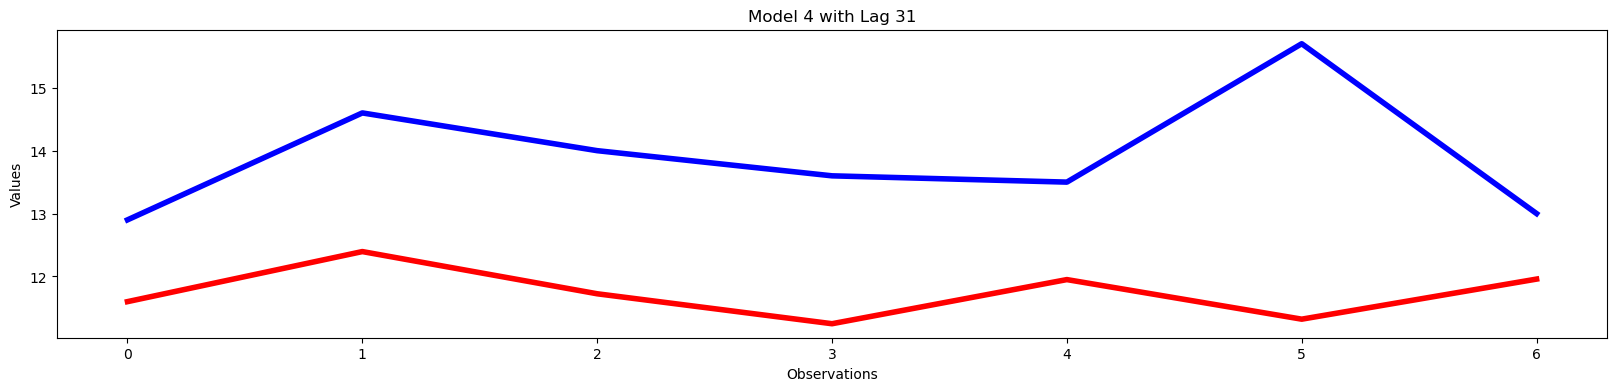

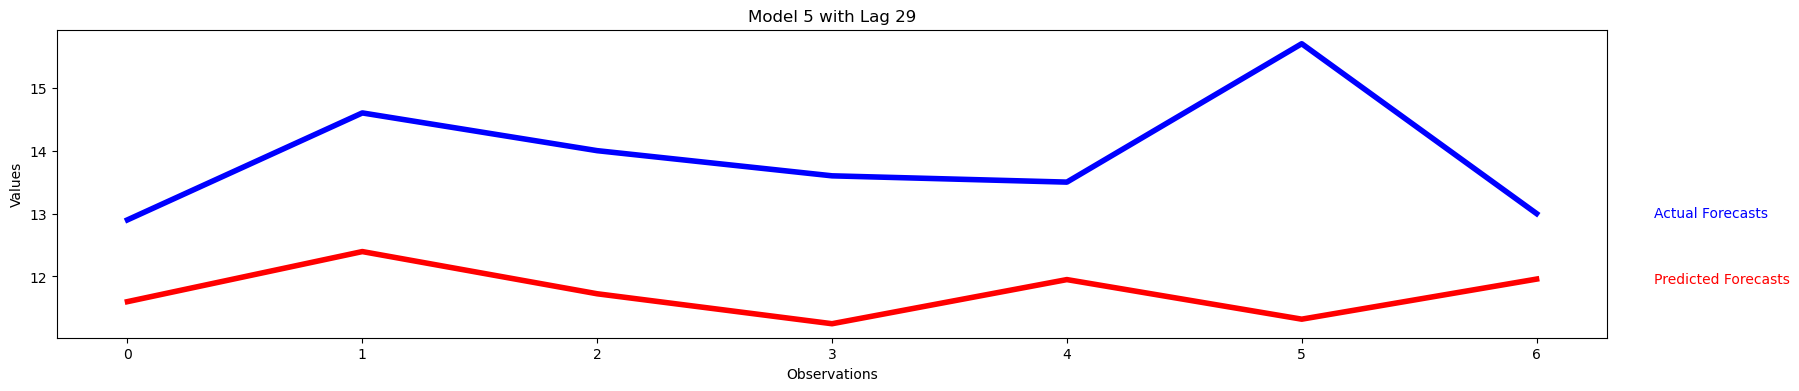

In [51]:
EvaluationMetric.plot_forecast(expected_forecast, ma_predictions, errors_to_test, with_lags=True)

### Follow-up
- What can we determine from this?
- Which AR(p) lag performs the best?
- Can we do better?